In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from time import time
from datetime import datetime

import matplotlib.pyplot as plt

import qutip as qp
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver
from qiskit_dynamics import DiscreteSignal

/Users/korbinianpalmarsson/anaconda3/envs/pennylane/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Comparing different hardware

In [2]:
def expfit(x, y):
    y = np.log(y)
    coeff = np.polyfit(x, y, 1) # y=c1 e^(c0 x) => logy = c0 x + log(c1)
    return coeff

In [3]:
data = [
    np.load("data/2023-09-18_Forward-pass_PL-QUTIP-QISKIT-GPU.npz", allow_pickle=True)["PennyLane"].item(),
    np.load("data/2023-09-07_Forward-pass_PL-QUTIP-QISKIT-INTEL-i7-1260P.npz", allow_pickle=True)["PennyLane"].item(),
    np.load("data/2023-09-15_Forward-pass_PL-QUTIP-QISKIT-M1.npz", allow_pickle=True)["PennyLane"].item(),
]

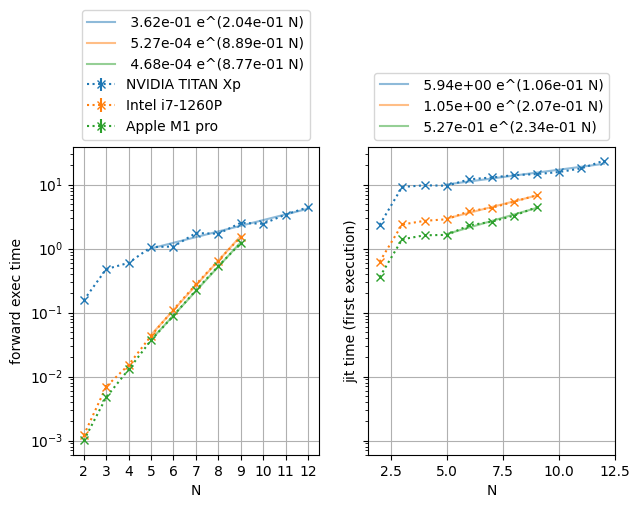

In [4]:
from_ = 3

fig, axs = plt.subplots(ncols=2, figsize=(7,4), sharey=True)
color = ["tab:blue", "tab:orange", "tab:green", "black", "blue"] * 5
labels = ["NVIDIA TITAN Xp", "Intel i7-1260P", "Apple M1 pro",]
ax = axs[0]
for i, label in enumerate(labels):
    dat = data[i]
    x, y = np.array(dat["n_wiress"]), np.array(dat["dtss"])
    x = x[np.arange(len(y))] # because we dont simulate all sizes with qutip
    coeff = expfit(x[from_:], y[from_:])
    fit_string = f" {np.exp(coeff[1]):.2e} e^({coeff[0]:.2e} N)"
    ax.errorbar(x, dat["dtss"], dat["ddtss"], fmt="x:", label=label, color=color[i])
    ax.plot(x[from_:], np.exp(coeff[1])*np.exp(coeff[0]*np.array(x[from_:])), color=color[i], label=fit_string, alpha=0.5)
ax.set_yscale("log")
ax.set_ylabel("forward exec time")
ax.set_xlabel("N")
ax.set_xticks(np.arange(2, 13))
ax.legend(bbox_to_anchor=(0.5, 1), loc="lower center")
ax.grid()

from_jit = 3

ax = axs[1]
for i, label in enumerate(labels):
    dat = data[i]
    x, y = np.array(dat["n_wiress"]), np.array(dat["dt_jit"])
    x = x[np.arange(len(y))] # because we dont simulate all sizes with qutip
    coeff = expfit(x[from_jit:], y[from_jit:])
    fit_string = f" {np.exp(coeff[1]):.2e} e^({coeff[0]:.2e} N)"
    ax.plot(x, dat["dt_jit"], "x:", color=color[i])
    ax.plot(x[from_jit:], np.exp(coeff[1])*np.exp(coeff[0]*np.array(x[from_jit:])), color=color[i], label=fit_string, alpha=0.5)
ax.legend(bbox_to_anchor=(0.5, 1), loc="lower center")
ax.set_yscale("log")
ax.set_ylabel("jit time (first execution)")
ax.set_xlabel("N")
np.arange(2, 13)

ax.grid()

plt.savefig("plots/Forward-pass_PL_hardware.png", dpi=500)